ASSIGNMENT 3

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt



In [19]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0



In [20]:

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=2020
)


In [21]:
X_train = np.expand_dims(X_train, -1)
X_validation = np.expand_dims(X_validation, -1)
X_test = np.expand_dims(X_test, -1)



In [5]:
# Define the CNN model
def create_model():
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



In [9]:
# Metrics Calculation
def calculate_metrics(model, X_pool):
    predictions = model.predict(X_pool, batch_size=256)
    features = model.predict(X_pool, batch_size=512)

     # Least Confidence
    least_conf_scores = np.max(predictions, axis=1)
    avg_least_confidence = np.mean(least_conf_scores)

    # Prediction Entropy
    pred_entropies = entropy(predictions.T)
    avg_prediction_entropy = np.mean(pred_entropies)

    # Margin Sampling
    sorted_preds = -np.sort(-predictions, axis=1)
    margins = sorted_preds[:, 0] - sorted_preds[:, 1]
    avg_margin_sampling = np.mean(margins)

    # Cosine Similarity (Feature Diversity)
    similarities = cosine_similarity(features)
    diversities = 1 - similarities.sum(axis=1)
    avg_cosine_similarity = np.mean(diversities)

    # L2 Norm
    l2_norms = np.linalg.norm(features, axis=1)
    avg_l2_norm = np.mean(l2_norms)

    # KL Divergence
    uniform_dist = np.ones_like(predictions) / predictions.shape[1]
    kl_divergences = np.sum(predictions * np.log(predictions / uniform_dist), axis=1)
    avg_kl_divergence = np.mean(kl_divergences)

    return {
        "Average Least Confidence": avg_least_confidence,
        "Average Prediction Entropy": avg_prediction_entropy,
        "Average Margin Sampling": avg_margin_sampling,
        "Average Cosine Similarity": avg_cosine_similarity,
        "Average L2 Norm": avg_l2_norm,
        "Average KL Divergence": avg_kl_divergence
    }



In [10]:
# Train model without active learning
model_without_al = create_model()
history_without_al = model_without_al.fit(
    X_train, y_train, epochs=20, batch_size=512, validation_data=(X_validation, y_validation)
)
val_acc_without_al = model_without_al.evaluate(X_validation, y_validation, verbose=0)[1]
print(f'Validation Accuracy without Active Learning: {val_acc_without_al:.2f}')






/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 53s 536ms/step - accuracy: 0.5699 - loss: 1.3291 - val_accuracy: 0.8064 - val_loss: 0.5230
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 514ms/step - accuracy: 0.8087 - loss: 0.5237 - val_accuracy: 0.8511 - val_loss: 0.4124
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 87s 564ms/step - accuracy: 0.8462 - loss: 0.4266 - val_accuracy: 0.8677 - val_loss: 0.3686
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 84s 585ms/step - accuracy: 0.8609 - loss: 0.3821 - val_accuracy: 0.8728 - val_loss: 0.3454
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 77s 534ms/step - accuracy: 0.8738 - loss: 0.3518 - val_accuracy: 0.8791 - val_loss: 0.3311
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 532ms/step - accuracy: 0.8846 - loss: 0.3208 - val_accuracy: 0.8869 - val_loss: 0.3100
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 78s 493ms/step - accuracy: 0.8864 - loss: 0.3112 - val_accuracy: 0.8874 - val_loss: 0.3064
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 86s 541ms/step - accuracy: 0.8914 - loss: 0.2967 - val_accu

In [11]:
# Active learning selection
n_samples = 1000
selected_indices = np.random.choice(X_validation.shape[0], n_samples, replace=False)  # Random selection
X_selected = X_validation[selected_indices]
y_selected = y_validation[selected_indices]


In [12]:
# Augment training data with selected samples
X_train_al = np.concatenate([X_train, X_selected], axis=0)
y_train_al = np.concatenate([y_train, y_selected], axis=0)


In [13]:
# Train model with active learning
model_with_al = create_model()
history_with_al = model_with_al.fit(
    X_train_al, y_train_al, epochs=25, batch_size=256, validation_data=(X_validation, y_validation)
)
val_acc_with_al = model_with_al.evaluate(X_validation, y_validation, verbose=0)[1]
print(f'Validation Accuracy with Active Learning: {val_acc_with_al:.2f}')



Epoch 1/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 52s 266ms/step - accuracy: 0.6274 - loss: 1.0723 - val_accuracy: 0.8357 - val_loss: 0.4549
Epoch 2/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 45s 237ms/step - accuracy: 0.8353 - loss: 0.4582 - val_accuracy: 0.8619 - val_loss: 0.3797
Epoch 3/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 85s 251ms/step - accuracy: 0.8564 - loss: 0.3949 - val_accuracy: 0.8745 - val_loss: 0.3395
Epoch 4/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.8734 - loss: 0.3491 - val_accuracy: 0.8809 - val_loss: 0.3297
Epoch 5/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.8830 - loss: 0.3212 - val_accuracy: 0.8842 - val_loss: 0.3101
Epoch 6/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 83s 250ms/step - accuracy: 0.8899 - loss: 0.2973 - val_accuracy: 0.8907 - val_loss: 0.2973
Epoch 7/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 80s 240ms/step - accuracy: 0.8938 - loss: 0.2901 - val_accuracy: 0.8913 - val_loss: 0.2936
Epoch 8/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.9015 - loss: 0

In [16]:
# Calculate metrics for the validation pool
metrics_before_al = calculate_metrics(model_without_al, X_validation)
metrics_after_al = calculate_metrics(model_with_al, X_validation)



47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step


In [22]:
print("\nMetrics Before Active Learning:")
for metric, value in metrics_before_al.items():
    print(f"{metric}: {value:.4f}")




Metrics Before Active Learning:
Average Least Confidence: 0.9088
Average Prediction Entropy: 0.2400
Average Margin Sampling: 0.8368
Average Cosine Similarity: -1470.6244
Average L2 Norm: 0.9255
Average KL Divergence: 2.0626


In [18]:
print("\nMetrics After Active Learning:")
for metric, value in metrics_after_al.items():
    print(f"{metric}: {value:.4f}")



Metrics After Active Learning:
Average Least Confidence: 0.9391
Average Prediction Entropy: 0.1534
Average Margin Sampling: 0.8871
Average Cosine Similarity: -1370.4650
Average L2 Norm: 0.9508
Average KL Divergence: 2.1492


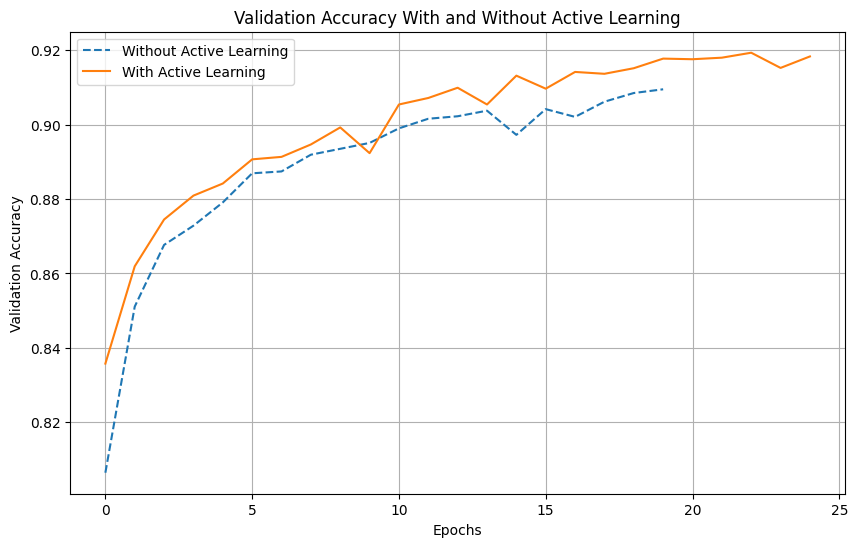

In [14]:

# Plot accuracy graphs
plt.figure(figsize=(10, 6))
plt.plot(history_without_al.history['val_accuracy'], label='Without Active Learning', linestyle='--')
plt.plot(history_with_al.history['val_accuracy'], label='With Active Learning', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy With and Without Active Learning')
plt.legend()
plt.grid(True)
plt.show()

Report and Analysis:
Effective Active Learning Strategy:
Reflect on strategies used such as
Uncertainty Sampling which is Selecting samples the model is least confident about
and Diversity Sampling that is Choosing diverse data points to maximize model learning.
Justify the most effective strategy for our dataset and explain why it aligns with the dataset's characteristics such as class imbalance and noise levels.